In [1]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from typing import List, Tuple

In [2]:
def hamming_kernel(data: pd.DataFrame, damping_param: float=0.6) -> np.ndarray:
    cardinality = data.nunique()
    n = data.shape[0]
    k_j = np.ones(shape=(n, n))

    for col in range(len(cardinality)):
        dhamming_j = np.not_equal.outer(
            data.iloc[:, col].values,
            data.iloc[:, col].values
        )
        k_j = (
            (damping_param**2) * (cardinality[col] - 1 - dhamming_j) +
            (2 * damping_param - 1) * dhamming_j + 1) * k_j

    kern_diag = 1 / np.sqrt(np.diag(k_j))
    W = k_j * np.outer(kern_diag, kern_diag)

    return W


def sra(kernel_matrix: np.ndarray, anomaly_threshold: float=0.4) -> Tuple[np.ndarray, np.ndarray, int]:
    n = kernel_matrix.shape[0]
    ident = np.zeros((n, n), float)
    np.fill_diagonal(ident, 1.)

    # Let D be the degree matrix of each vertex corresponding
    # the the row sum of the similarity matrix W
    d = np.sum(kernel_matrix, axis=1)
    D = np.zeros((n, n), float)
    np.fill_diagonal(D, d)
    
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))
    # Let L be the symmetric normalized Laplacian
    L = ident - np.dot(D_inv_sqrt, kernel_matrix).dot(D_inv_sqrt)
    
    # Extract the 2 non-principal eigenvectors.
    #
    # The eig() function returns 2 arrays: the
    # first represents eigenvalues, the second
    # eigenvectors. The eigenvectors are not
    # arranged in order of magnitude. We sort
    # and then sample the second and third vectors
    eig_vals, eig_vecs = np.linalg.eig(L)
    eig_vecs = eig_vecs[:, eig_vals.argsort()[::][1:]]

    # Components of the first non-principal
    # eigenvectors in the feature space.
    #
    # Note that here we're just duplicating
    # D_sqrt column-wise so that its dimensionality
    # is equal to that of npeigen
    z = np.sqrt(d) * eig_vecs[:, 0]
    
    # Let C_p be the positive class and and C_n
    # the negative class assigned based on the
    # sign of the 1st non-principal eigenvector
    # component of z
    C = np.sign(z)
    C_cnt = np.unique(C, return_counts=True)
    C_cnt = pd.DataFrame(
        data=np.array(C_cnt[1])[np.newaxis],
        columns=C_cnt[0])

    if C_cnt.iloc[[0]].min(axis=1)[0]/n >= 0.4:
        mFLAG = 1
        f = np.max(np.abs(z)) - np.abs(z)
    else:
        if C_cnt[1][0] > C_cnt[-1][0]:
            mFLAG = 0
            f = -z
        else:
            mFLAG = 0
            f = z
    
    return eig_vecs, f, mFLAG


def plot_clusters(eig_vecs, anomaly_rank):
    p = plt.scatter(
        x=eig_vecs[:, 0],
        y=eig_vecs[:, 1],
        c=anomaly_rank,
        cmap='seismic'
    )
    p = plt.colorbar()

In [3]:
data = pd.read_csv(
    'assets/house-votes-84.data',
    header=None,
    names=[
        'affiliation',
        'handicapped-infants',
        'water-project-cost-sharing',
        'budget-resolution',
        'physician-fee-freeze',
        'el-salvador-aid',
        'religious-groups-in-schools',
        'anti-satellite-test-ban',
        'aid-to-nicaraguan-contras',
        'mx-missile',
        'immigration',
        'synfuels-corp-cutback',
        'education-spending',
        'superfund-right-to-sue',
        'crime',
        'duty-free-exports',
        'export-admin-act-south-africa'
    ],
    dtype='category'
)
affiliation = data.pop('affiliation')
data = data.apply(lambda x: x.cat.codes)
data.head()

,handicapped-infants,water-project-cost-sharing,budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corp-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-admin-act-south-africa
0,1,2,1,2,2,2,1,1,1,2,0,2,2,2,1,2
1,1,2,1,2,2,2,1,1,1,1,1,2,2,2,1,0
2,0,2,2,0,2,2,1,1,1,1,2,1,2,2,1,1
3,1,2,2,1,0,2,1,1,1,1,2,1,2,1,1,2
4,2,2,2,1,2,2,1,1,1,1,2,0,2,2,2,2


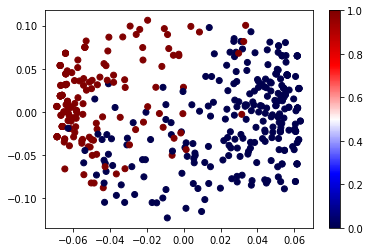

In [4]:
kernel = hamming_kernel(data)
eigens, anomaly_rank, mFLAG = sra(kernel)
plot_clusters(eigens, affiliation.cat.codes)

In [5]:
data = pd.read_csv(
    'assets/agaricus-lepiota.data',
    header=None,
    names=[
        'edible',
        'cap-shape',
        'cap-surface',
        'cap-color',
        'bruises',
        'odor',
        'gill-attachment',
        'gill-spacing',
        'gill-size',
        'gill-color',
        'stalk-shape',
        'stalk-root',
        'stalk-surface-above-ring',
        'stalk-surface-below-ring',
        'stalk-color-above-ring',
        'stalk-color-below-ring',
        'veil-type',
        'veil-color',
        'ring-number',
        'ring-type',
        'spore-print-color',
        'population',
        'habitat'
    ],
    dtype='category'
)
edible = data.pop('edible')
data = data.apply(lambda x: x.cat.codes)
data.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,5,2,4,1,6,1,0,1,4,0,...,2,7,7,0,2,1,4,2,3,5
1,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
2,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
3,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
4,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1


/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


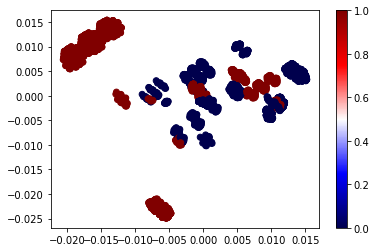

In [6]:
kernel = hamming_kernel(data)
eigens, anomaly_rank, mFLAG = sra(kernel)
plot_clusters(eigens, edible.cat.codes)

## SRA Over Partial Data

In [7]:
n_poisonous = edible.cat.codes.sum()
poisonous = data.loc[edible.cat.codes == 1]
non_poisonous = data.loc[edible.cat.codes == 0]

In [8]:
batch_size = 1000
processed = 0

# while processed < non_poisonous.shape[0]:
#     _data = pd.concat([
#         poisonous,
#         non_poisonous.iloc[processed:(processed + batch_size), :]
#     ])
#     _labels = [1] * poisonous.shape[0] + [0] * batch_size
#     kernel = hamming_kernel(_data)
#     eigens, anomaly_rank, mFLAG = sra(kernel)
#     plot_clusters(eigens, _labels)
# 
#     processed += batch_size

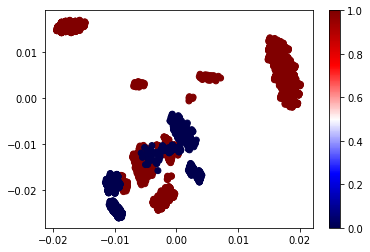

In [9]:
_data = pd.concat([
    poisonous,
    non_poisonous.iloc[processed:(processed + batch_size), :]
])
_labels = [1] * poisonous.shape[0] + [0] * batch_size
kernel = hamming_kernel(_data)
eigens, anomaly_rank, mFLAG = sra(kernel)
plot_clusters(eigens, _labels)

processed += batch_size

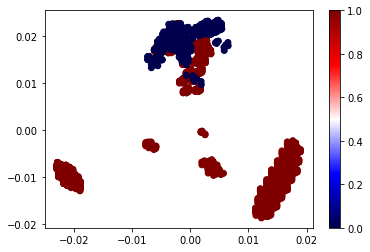

In [10]:
_data = pd.concat([
    poisonous,
    non_poisonous.iloc[processed:(processed + batch_size), :]
])
_labels = [1] * poisonous.shape[0] + [0] * batch_size
kernel = hamming_kernel(_data)
eigens, anomaly_rank, mFLAG = sra(kernel)
plot_clusters(eigens, _labels)

processed += batch_size

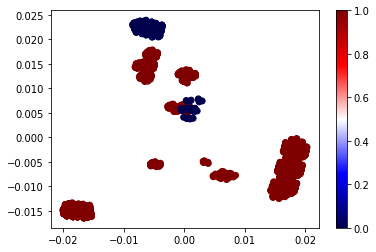

In [11]:
_data = pd.concat([
    poisonous,
    non_poisonous.iloc[processed:(processed + batch_size), :]
])
_labels = [1] * poisonous.shape[0] + [0] * batch_size
kernel = hamming_kernel(_data)
eigens, anomaly_rank, mFLAG = sra(kernel)
plot_clusters(eigens, _labels)

processed += batch_size